In [1]:
import numpy as np
from casadi import *

# Add do_mpc to path. This is not necessary if it was installed via pip.
import sys
import os
rel_do_mpc_path = os.path.join('..','..','..')
sys.path.append(rel_do_mpc_path)

# Import do_mpc package:
import do_mpc

In [2]:
model_type = 'continuous' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)

In [3]:
phi = model.set_variable(var_type='_x', var_name='phi', shape=(3,1))
dphi = model.set_variable(var_type='_x', var_name='dphi', shape=(3,1))

# Two states for the desired (set) motor position:
phi_m_set = model.set_variable(var_type='_u', var_name='phi_m_set', shape=(2,1))

# Two additional states for the true motor position:
phi_m = model.set_variable(var_type='_x', var_name='phi_m', shape=(2,1))

In [4]:
# State measurements
phi_meas = model.set_meas('phi_1_meas', phi, meas_noise=True)

# Input measurements
phi_m_set_meas = model.set_meas('phi_m_set_meas', phi_m_set, meas_noise=False)

In [5]:
Theta_1 = model.set_variable('parameter', 'Theta_1')
Theta_2 = model.set_variable('parameter', 'Theta_2')
Theta_3 = model.set_variable('parameter', 'Theta_3')

c = np.array([2.697,  2.66,  3.05, 2.86])*1e-3
d = np.array([6.78,  8.01,  8.82])*1e-5

In [6]:
model.set_rhs('phi', dphi)

dphi_next = vertcat(
    -c[0]/Theta_1*(phi[0]-phi_m[0])-c[1]/Theta_1*(phi[0]-phi[1])-d[0]/Theta_1*dphi[0],
    -c[1]/Theta_2*(phi[1]-phi[0])-c[2]/Theta_2*(phi[1]-phi[2])-d[1]/Theta_2*dphi[1],
    -c[2]/Theta_3*(phi[2]-phi[1])-c[3]/Theta_3*(phi[2]-phi_m[1])-d[2]/Theta_3*dphi[2],
)

model.set_rhs('dphi', dphi_next, process_noise = False)

tau = 1e-2
model.set_rhs('phi_m', 1/tau*(phi_m_set - phi_m))


In [7]:
model.setup()

In [8]:
mhe = do_mpc.estimator.MHE(model, ['Theta_1'])

In [9]:
setup_mhe = {
    't_step': 0.1,
    'n_horizon': 10,
    'store_full_solution': True,
    'meas_from_data': True
}
mhe.set_param(**setup_mhe)

In [10]:
P_v = np.diag(np.array([1,1,1]))
P_x = np.eye(8)
P_p = 10*np.eye(1)

mhe.set_default_objective(P_x, P_v, P_p)

In [11]:
p_template_mhe = mhe.get_p_template()

In [12]:
def p_fun_mhe(t_now):
    p_template_mhe['Theta_2'] = 2.25e-4
    p_template_mhe['Theta_3'] = 2.25e-4
    return p_template_mhe

In [13]:
mhe.set_p_fun(p_fun_mhe)

In [14]:
mhe.bounds['lower','_u', 'phi_m_set'] = -2*np.pi
mhe.bounds['upper','_u', 'phi_m_set'] = 2*np.pi

mhe.bounds['lower','_p_est', 'Theta_1'] = 1e-5
mhe.bounds['upper','_p_est', 'Theta_1'] = 1e-3

In [15]:
mhe.setup()

In [16]:
simulator = do_mpc.simulator.Simulator(model)

In [17]:
# Instead of supplying a dict with the splat operator (**), as with the optimizer.set_param(),
# we can also use keywords (and call the method multiple times, if necessary):
simulator.set_param(t_step = 0.1)

In [20]:
p_template_sim = simulator.get_p_template()

In [21]:
def p_fun_sim(t_now):
    p_template_sim['Theta_1'] = 2.25e-4
    p_template_sim['Theta_2'] = 2.25e-4
    p_template_sim['Theta_3'] = 2.25e-4
    return p_template_sim

In [22]:
simulator.set_p_fun(p_fun_sim)

In [23]:
simulator.setup()

In [24]:
x0 = np.pi*np.array([1, 1, -1.5, 1, -5, 5, 0, 0]).reshape(-1,1)

In [25]:
x0_mhe = x0*(1+0.5*np.random.randn(8,1))

In [26]:
simulator.x0 = x0
mhe.x0 = x0_mhe
mhe.p_est0 = 1e-4

In [27]:
mhe.set_initial_guess()

In [28]:
import matplotlib.pyplot as plt
import matplotlib as mpl
# Customizing Matplotlib:
mpl.rcParams['font.size'] = 18
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.grid'] = True

In [29]:
mhe_graphics = do_mpc.graphics.Graphics(mhe.data)
sim_graphics = do_mpc.graphics.Graphics(simulator.data)

In [30]:
%%capture
# We just want to create the plot and not show it right now. This "inline magic" suppresses the output.
fig, ax = plt.subplots(3, sharex=True, figsize=(16,9))
fig.align_ylabels()

# We create another figure to plot the parameters:
fig_p, ax_p = plt.subplots(1, figsize=(16,4))

In [31]:
%%capture
for g in [sim_graphics, mhe_graphics]:
    # Plot the angle positions (phi_1, phi_2, phi_2) on the first axis:
    g.add_line(var_type='_x', var_name='phi', axis=ax[0])
    ax[0].set_prop_cycle(None)
    g.add_line(var_type='_x', var_name='dphi', axis=ax[1])
    ax[1].set_prop_cycle(None)

    # Plot the set motor positions (phi_m_1_set, phi_m_2_set) on the second axis:
    g.add_line(var_type='_u', var_name='phi_m_set', axis=ax[2])
    ax[2].set_prop_cycle(None)

    g.add_line(var_type='_p', var_name='Theta_1', axis=ax_p)


ax[0].set_ylabel('angle position [rad]')
ax[1].set_ylabel('angular \n velocity [rad/s]')
ax[2].set_ylabel('motor angle [rad]')
ax[2].set_xlabel('time [s]')

In [32]:
sim_graphics.result_lines

In [33]:
# First element for state phi:
sim_graphics.result_lines['_x', 'phi', 0]

In [34]:
for line_i in sim_graphics.result_lines.full:
    line_i.set_alpha(0.4)
    line_i.set_linewidth(6)

In [35]:
ax[0].legend(sim_graphics.result_lines['_x', 'phi'], '123', title='Sim.', loc='center right')
ax[1].legend(mhe_graphics.result_lines['_x', 'phi'], '123', title='MHE', loc='center right')

In [36]:
ax_p.legend(sim_graphics.result_lines['_p', 'Theta_1']+mhe_graphics.result_lines['_p', 'Theta_1'], ['True','Estim.'])

In [37]:
def random_u(u0):
    # Hold the current value with 80% chance or switch to new random value.
    u_next = (0.5-np.random.rand(2,1))*np.pi # New candidate value.
    switch = np.random.rand() >= 0.8 # switching? 0 or 1.
    u0 = (1-switch)*u0 + switch*u_next # Old or new value.
    return u0

In [38]:
%%capture
np.random.seed(999) #make it repeatable

u0 = np.zeros((2,1))
for i in range(50):
    u0 = random_u(u0) # Control input
    v0 = 0.1*np.random.randn(model.n_v,1) # measurement noise
    y0 = simulator.make_step(u0, v0=v0)
    x0 = mhe.make_step(y0) # MHE estimation step

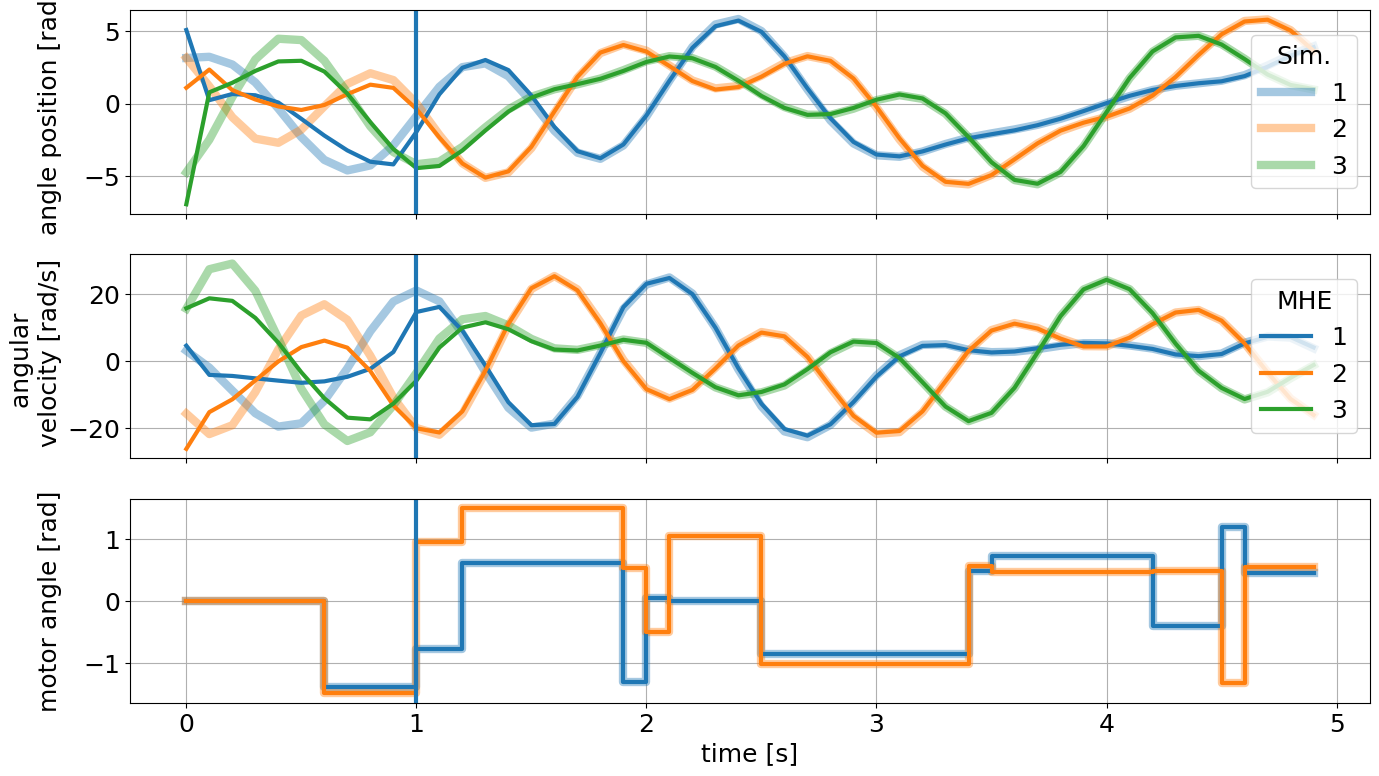

In [39]:
sim_graphics.plot_results()
mhe_graphics.plot_results()
# Reset the limits on all axes in graphic to show the data.
mhe_graphics.reset_axes()

# Mark the time after a full horizon is available to the MHE.
ax[0].axvline(1)
ax[1].axvline(1)
ax[2].axvline(1)

# Show the figure:
fig

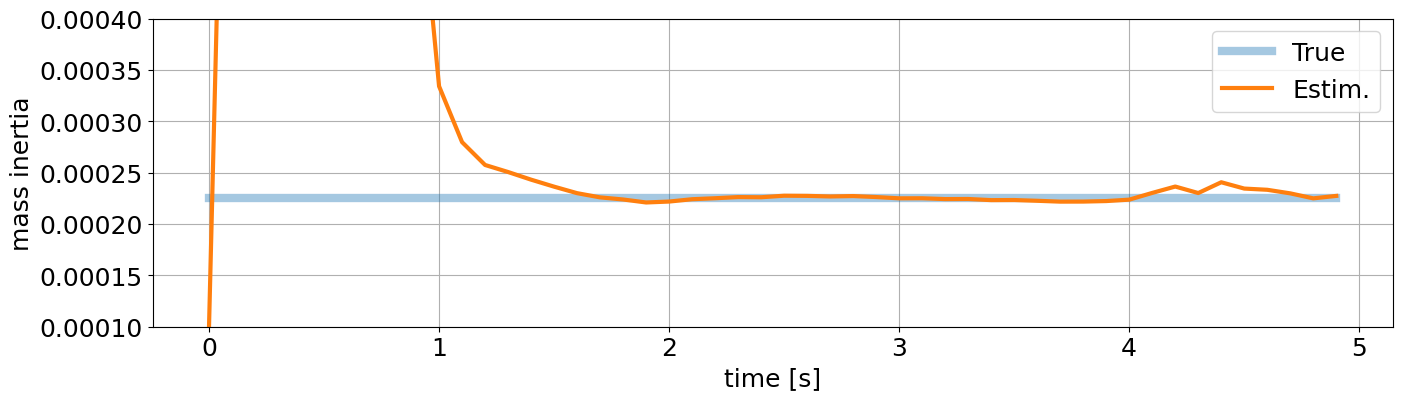

In [40]:
ax_p.set_ylim(1e-4, 4e-4)
ax_p.set_ylabel('mass inertia')
ax_p.set_xlabel('time [s]')
fig_p